In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import os
import pandas as pd
import pickle
import scipy.ndimage as ndi
import SimpleITK as sitk
import warnings

from constants import Constants
constants = Constants()

from IPython.display import Image
from nilearn import plotting
from pathlib import Path

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
ROOT = constants.dataset_path
PROCESSED = ROOT / 'processed'

LABELS = PROCESSED / 'lesion_findings.pickle'
MASKS = ROOT / 'ProstateX_masks'

labels = pd.read_pickle(LABELS)
labels

,ProxID,ClinSig,T2,ADC,KTrans
0,ProstateX-0000,[True],data\processed\ProstateX-0000_t2_tse_tra_t2_ts...,data\processed\ProstateX-0000_ep2d_diff_tra_ep...,data\processed\ProstateX-0000-Ktrans.nii.gz
1,ProstateX-0001,[False],data\processed\ProstateX-0001_t2_tse_tra_t2_ts...,data\processed\ProstateX-0001_ep2d_diff_tra_ep...,data\processed\ProstateX-0001-Ktrans.nii.gz
2,ProstateX-0002,"[True, False]",data\processed\ProstateX-0002_t2_tse_tra_t2_ts...,data\processed\ProstateX-0002_ep2d_diff_tra_ep...,data\processed\ProstateX-0002-Ktrans.nii.gz
3,ProstateX-0003,"[False, False]",data\processed\ProstateX-0003_t2_tse_tra_t2_ts...,data\processed\ProstateX-0003_ep2d_diff_tra_ep...,data\processed\ProstateX-0003-Ktrans.nii.gz
4,ProstateX-0004,[False],data\processed\ProstateX-0004_t2_tse_tra_t2_ts...,data\processed\ProstateX-0004_ep2d_diff_tra_ep...,data\processed\ProstateX-0004-Ktrans.nii.gz
...,...,...,...,...,...
199,ProstateX-0199,"[True, True]",data\processed\ProstateX-0199_t2_tse_tra_t2_ts...,data\processed\ProstateX-0199_diffusie-3Scan-4...,data\processed\ProstateX-0199-Ktrans.nii.gz
200,ProstateX-0200,"[True, False]",data\processed\ProstateX-0200_t2_tse_tra_t2_ts...,data\processed\ProstateX-0200_diffusie-3Scan-4...,data\processed\ProstateX-0200-Ktrans.nii.gz
201,ProstateX-0201,[True],data\processed\ProstateX-0201_t2_tse_tra_t2_ts...,data\processed\ProstateX-0201_diffusie-3Scan-4...,data\processed\ProstateX-0201-Ktrans.nii.gz
202,ProstateX-0202,"[True, False]",data\processed\ProstateX-0202_t2_tse_tra_t2_ts...,data\processed\ProstateX-0202_diffusie-3Scan-4...,data\processed\ProstateX-0202-Ktrans.nii.gz


In [3]:
def get_patient_data(patient_id, labels):
    patient_data = {}
    for c, prox_id in enumerate(labels.ProxID):
        if prox_id == patient_id:
            patient_data['ProxID'] = labels.ProxID.iloc[c]
            patient_data['ClinSig'] = labels.ClinSig.iloc[c]
            patient_data['T2'] = labels.T2.iloc[c]
            patient_data['ADC'] = labels.ADC.iloc[c]
            patient_data['KTrans'] = labels.KTrans.iloc[c]
    return patient_data

def get_patientID(filename):
    return filename[:14]

In [5]:
patients = {}

for patient_id in labels.ProxID:
    patient = get_patient_data(patient_id=patient_id, labels=labels)
    
    patients[patient_id] = {}
    patients[patient_id]['data'] = {}
    patients[patient_id]['images'] = {}
    patients[patient_id]['data']['ProxID'] = patient['ProxID']
    patients[patient_id]['data']['ClinSig'] = patient['ClinSig']
    patients[patient_id]['images']['T2'] = patient['T2']
    patients[patient_id]['images']['ADC'] = patient['ADC']
    patients[patient_id]['images']['KTrans'] = patient['KTrans']
    patients[patient_id]['mask'] = os.path.join(MASKS, patient_id + '_msk.nrrd')

# Display an example

All data:
{'data': {'ProxID': 'ProstateX-0100', 'ClinSig': [False, False, False]}, 'images': {'T2': WindowsPath('data/processed/ProstateX-0100_t2_tse_tra_t2_tse_tra.nii.gz'), 'ADC': WindowsPath('data/processed/ProstateX-0100_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_ADC.nii.gz'), 'KTrans': WindowsPath('data/processed/ProstateX-0100-Ktrans.nii.gz')}, 'mask': 'data\\ProstateX_masks\\ProstateX-0100_msk.nrrd'}

Patient data:
{'ProxID': 'ProstateX-0100', 'ClinSig': [False, False, False]}

Available images:
{'T2': WindowsPath('data/processed/ProstateX-0100_t2_tse_tra_t2_tse_tra.nii.gz'), 'ADC': WindowsPath('data/processed/ProstateX-0100_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_ADC.nii.gz'), 'KTrans': WindowsPath('data/processed/ProstateX-0100-Ktrans.nii.gz')}

Prostate lesion mask:
data\ProstateX_masks\ProstateX-0100_msk.nrrd


Images shape:
T2: (384, 384, 21)
ADC: (84, 128, 19)
Ktrans: (128, 128, 16)
Mask: (21, 384, 384)



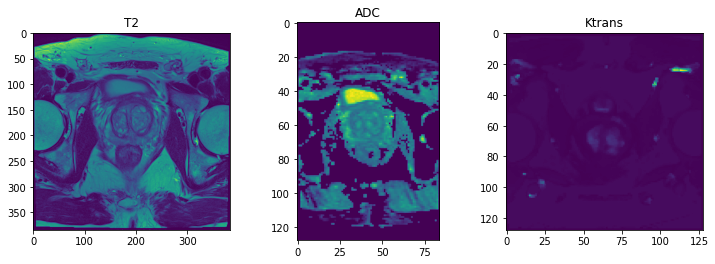

In [6]:
# Display patients map example
patient_id_example = 'ProstateX-0100'

print(
    f'All data:\n{patients[patient_id_example]}\n\n'
    f'Patient data:\n{patients[patient_id_example]["data"]}\n\n'
    f'Available images:\n{patients[patient_id_example]["images"]}\n\n'
    f'Prostate lesion mask:\n{patients[patient_id_example]["mask"]}\n\n'
)

t2_image = nib.load(patients[patient_id_example]['images']['T2']).get_data()
adc_image = nib.load(patients[patient_id_example]['images']['ADC']).get_data()
ktrans_image = nib.load(patients[patient_id_example]['images']['KTrans']).get_data()

mask = sitk.ReadImage(patients[patient_id_example]["mask"])
prostate_mask_arr = sitk.GetArrayFromImage(mask)

print(
    f'Images shape:\n'
    f'T2: {t2_image.shape}\n'
    f'ADC: {adc_image.shape}\n'
    f'Ktrans: {ktrans_image.shape}\n'
    f'Mask: {prostate_mask_arr.shape}\n'
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90))
ax1.set_title('T2');

ax2.imshow(ndi.rotate(adc_image[:, :, adc_image.shape[2]//2], 90))
ax2.set_title('ADC');

ax3.imshow(ndi.rotate(ktrans_image[:, :, ktrans_image.shape[2]//2], 90))
ax3.set_title('Ktrans');

## Plot series 

In [7]:
def plot_nifti(example_img):
    fig_rows = 2
    fig_cols = 2
    n_subplots = fig_rows * fig_cols
    n_slice = example_img.shape[2]
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(example_img[:, :, img], 90))
        
        
    plt.tight_layout()
    plt.show()

T2-weighted series:



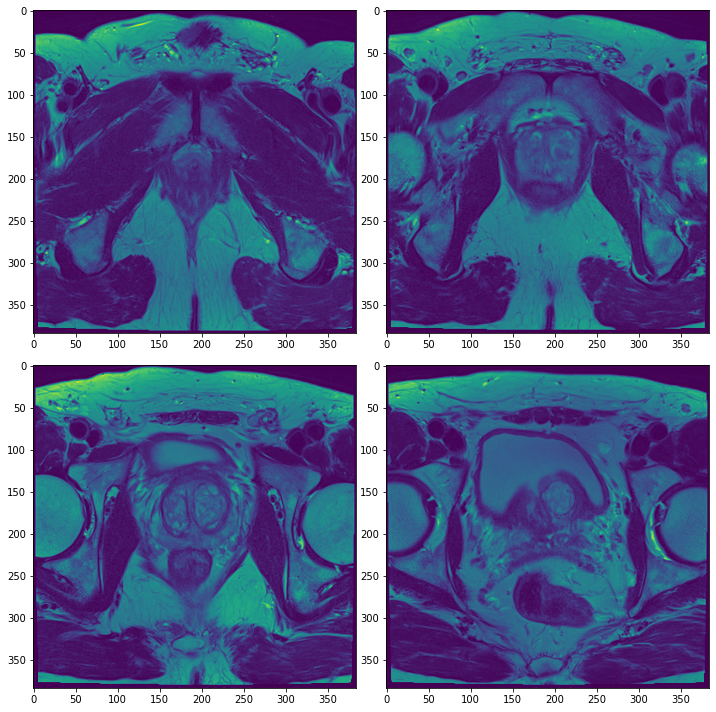

In [8]:
print(f'T2-weighted series:\n')
plot_nifti(t2_image)

ADC series:



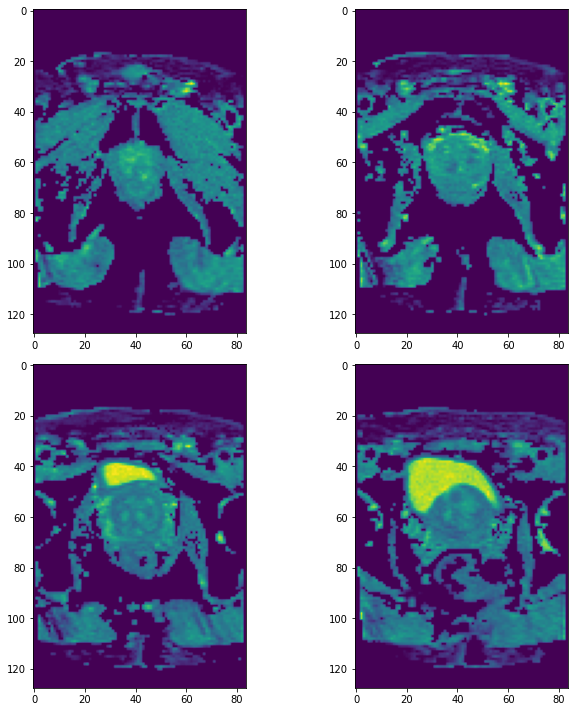

In [9]:
print(f'ADC series:\n')
plot_nifti(adc_image)

KTrans series:



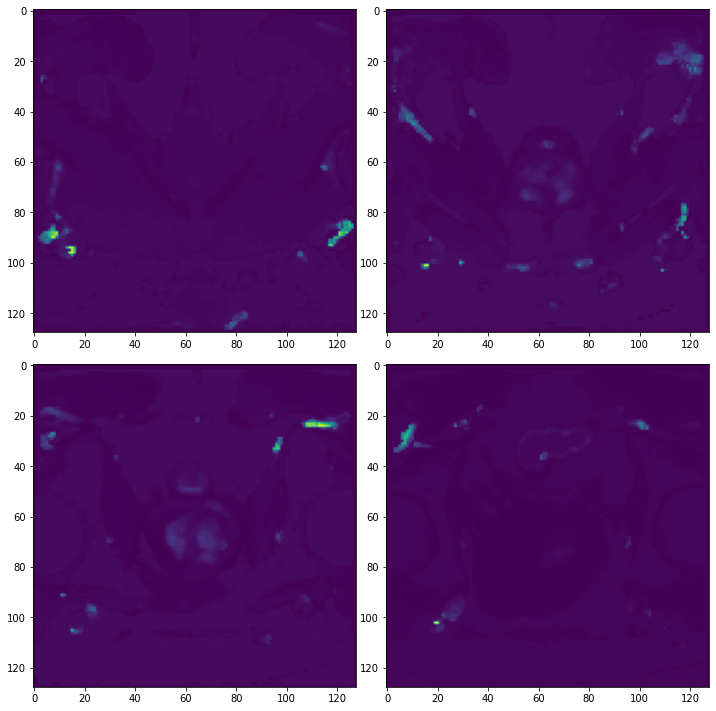

In [10]:
print(f'KTrans series:\n')
plot_nifti(ktrans_image)